# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

# Sentence Embedding

Sentence embedding takes one step further from word embedding and works directly with sentences. It makes vector representations of entire sentences and their semantic information. Here I'll be using Googles Universal Sentence Encoder. In their 2018 paper [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175) the authors explain how they create the sentence embedding models and give instructions to implement them with Tensorflow.

In [20]:
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Preprocessing
import nltk
from nltk.collocations import *
from nltk import word_tokenize
import string

from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import ModelCheckpoint

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [3]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [4]:
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df

def drop_features(df):
    df = df[['statement','label']]
    return df

def lower_case(df):
    df['statement'] = df['statement'].apply(lambda x: x.lower())
    return df

In [5]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('lower_case', FunctionTransformer(lower_case))
])

In [6]:
df_train_clean = cleaning_pipeline.fit_transform(raw_train)
df_val_clean = cleaning_pipeline.transform(raw_val)
df_test_clean = cleaning_pipeline.transform(raw_test)

In [7]:
X_train_clean = df_train_clean['statement'].values
y_train_clean = df_train_clean['label'].values
X_val_clean = df_val_clean['statement'].values
y_val_clean = df_val_clean['label'].values
X_test_clean = df_test_clean['statement'].values
y_test_clean = df_test_clean['label'].values

In [8]:
df_train_clean.head()

,statement,label
0.0,says the annies list political group supports ...,0
1.0,when did the decline of coal start? it started...,1
2.0,"hillary clinton agrees with john mccain ""by vo...",1
3.0,health care reform legislation is likely to ma...,0
4.0,the economic turnaround started at the end of ...,1


In [9]:
X_train_clean[:2]

array(['says the annies list political group supports third-trimester abortions on demand.',
       'when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.'],
      dtype=object)

In [10]:
y_train_clean

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [11]:
X_train_clean.shape, y_train_clean.shape, X_val_clean.shape, y_val_clean.shape, X_test_clean.shape, y_test_clean.shape

((10240,), (10240,), (1284,), (1284,), (1267,), (1267,))

In [12]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train_clean)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

In [13]:
val_labels = le.transform(y_val_clean)
test_labels = le.transform(y_test_clean)

val_labels = np.asarray(tf.keras.utils.to_categorical(val_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

## Neural Networks

Sentence Embedding require very little preprocessing. The data doesn't have to be tokenized or padded, and stopwords and punctuation don't have to be removed, since the embedding should account for them.<br \>
I'll start using the Input layer to create models and embed using KerasLayer and Universal Sentence Encoder Large 5, which encodes bodies of text into high dimensional vectors. It was trained with a transformer encoder in a variety of data and we can input any variable lenght and it outputs a 512 dimensional vector. This module was first released in 2018 in the paper [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175).

In [21]:
in_layer = Input(shape=[], dtype=tf.string)
embedding_layer = KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-large/5',
                    trainable=False)(in_layer)
d1_layer = Dense(256,activation = 'relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(embedding_layer)
dropout = Dropout(0.2)(d1_layer)
classifier = Dense(2,activation = 'sigmoid')(dropout)

model = Model(in_layer,classifier)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 147,486,722
Trainable params: 131,842
Non-trainable params: 147,354,880
_________________________________________________________________


In [22]:
#create callback
filepath = 'best_model_01.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

history = model.fit(X_train_clean, 
          train_labels, 
          batch_size=128, 
          validation_data=(X_val_clean, val_labels), 
          epochs=50,
          callbacks=callbacks)

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 1.7496 - accuracy: 0.5625
Epoch 1: val_accuracy improved from -inf to 0.54206, saving model to best_model_01.hdf5
80/80 [==============================] - 151s 1s/step - loss: 1.7496 - accuracy: 0.5625 - val_loss: 0.7789 - val_accuracy: 0.5421
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5997
Epoch 2: val_accuracy improved from 0.54206 to 0.63396, saving model to best_model_01.hdf5
80/80 [==============================] - 122s 2s/step - loss: 0.6932 - accuracy: 0.5997 - val_loss: 0.6703 - val_accuracy: 0.6340
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.6170
Epoch 3: val_accuracy improved from 0.63396 to 0.64019, saving model to best_model_01.hdf5
80/80 [==============================] - 126s 2s/step - loss: 0.6704 - accuracy: 0.6170 - val_loss: 0.6693 - val_accuracy: 0.6402
Epoch 4/50
80/80 [==============================] - ETA: 0

In [24]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='training data')
    plt.plot(history.history['val_accuracy'], label='validation data')
    plt.title('Categorical Accuracy for Text Classification')
    plt.ylabel('Categorical Accuracy Value')
    plt.xlabel('No. epoch')
    plt.legend(loc='upper left')
    plt.show()
    return None

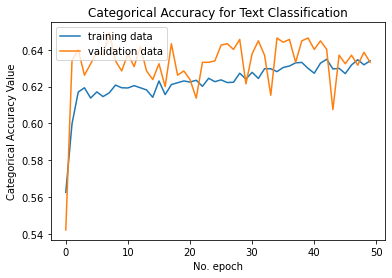

In [25]:
plot_accuracy(history)

In [34]:
in_layer = Input(shape=[], dtype=tf.string)
embedding_layer = KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                    trainable=False)(in_layer)
d1_layer = Dense(256,activation = 'relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(embedding_layer)
dropout = Dropout(0.2)(d1_layer)
classifier = Dense(2,activation = 'sigmoid')(dropout)

model2 = Model(in_layer,classifier)

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_5 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 256,929,666
Trainable params: 131,842
Non-trainable params: 256,797,824
_________________________________________________________________


In [35]:
filepath2 = 'best_model_02.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath2, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model2.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

history2 = model2.fit(X_train_clean, 
          train_labels, 
          batch_size=128, 
          validation_data=(X_val_clean, val_labels), 
          epochs=50,
          callbacks=callbacks)

Epoch 1/50
78/80 [============================>.] - ETA: 0s - loss: 1.7747 - accuracy: 0.5640
Epoch 1: val_accuracy did not improve from 0.64953
80/80 [==============================] - 6s 34ms/step - loss: 1.7496 - accuracy: 0.5655 - val_loss: 0.7740 - val_accuracy: 0.5771
Epoch 2/50
79/80 [============================>.] - ETA: 0s - loss: 0.6949 - accuracy: 0.5962
Epoch 2: val_accuracy did not improve from 0.64953
80/80 [==============================] - 2s 25ms/step - loss: 0.6947 - accuracy: 0.5961 - val_loss: 0.6711 - val_accuracy: 0.6262
Epoch 3/50
79/80 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6013
Epoch 3: val_accuracy did not improve from 0.64953
80/80 [==============================] - 2s 25ms/step - loss: 0.6735 - accuracy: 0.6013 - val_loss: 0.6718 - val_accuracy: 0.6153
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.6015
Epoch 4: val_accuracy did not improve from 0.64953
80/80 [=======================

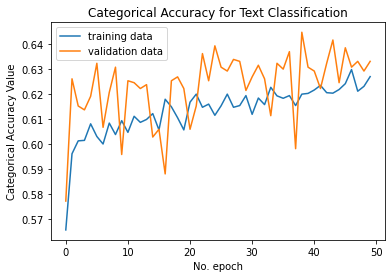

In [36]:
plot_accuracy(history2)

In [68]:
in_layer = Input(shape=[], dtype=tf.string)
embedding_layer = KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-large/5',
                    trainable=False)(in_layer)
d1_layer = Dense(256,activation = 'relu',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(embedding_layer)
dropout = Dropout(0.1)(d1_layer)
classifier = Dense(2,activation = 'sigmoid')(dropout)

model3 = Model(in_layer,classifier)

model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 147,486,722
Trainable params: 131,842
Non-trainable params: 147,354,880
_________________________________________________________________


In [69]:
filepath3 = 'best_model_03.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath3, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model3.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

history3 = model3.fit(X_train_clean, 
          train_labels, 
          batch_size=128, 
          validation_data=(X_val_clean, val_labels), 
          epochs=30,
          callbacks=callbacks)

Epoch 1/30
80/80 [==============================] - 177s 2s/step - loss: 1.7414 - accuracy: 0.5668 - val_loss: 0.7751 - val_accuracy: 0.5592
Epoch 2/30
80/80 [==============================] - 125s 2s/step - loss: 0.6917 - accuracy: 0.6064 - val_loss: 0.6820 - val_accuracy: 0.5919
Epoch 3/30
80/80 [==============================] - 126s 2s/step - loss: 0.6698 - accuracy: 0.6099 - val_loss: 0.6718 - val_accuracy: 0.6293
Epoch 4/30
80/80 [==============================] - 126s 2s/step - loss: 0.6709 - accuracy: 0.6116 - val_loss: 0.6654 - val_accuracy: 0.6363
Epoch 5/30
80/80 [==============================] - 127s 2s/step - loss: 0.6678 - accuracy: 0.6182 - val_loss: 0.6650 - val_accuracy: 0.6340
Epoch 6/30
80/80 [==============================] - 127s 2s/step - loss: 0.6673 - accuracy: 0.6186 - val_loss: 0.6744 - val_accuracy: 0.6160
Epoch 7/30
80/80 [==============================] - 123s 2s/step - loss: 0.6677 - accuracy: 0.6149 - val_loss: 0.6703 - val_accuracy: 0.6371
Epoch 8/30
80

I'll now switch to a different universal sentence encoder and use hub to embed it in my data.

In [38]:
# Ohe labels
le = LabelEncoder()

train_labels = le.fit_transform(y_train_clean)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

In [39]:
val_labels = le.transform(y_val_clean)
test_labels = le.transform(y_test_clean)

val_labels = np.asarray(tf.keras.utils.to_categorical(val_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [40]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [41]:
# convert sentences to embeddings
X_train = embed(df_train_clean['statement'])
X_val = embed(df_val_clean['statement'])
X_test = embed(df_test_clean['statement'])

In [57]:
model4 = Sequential()
model4.add(Dense(units=32, activation="relu"))
model4.add(Dense(units=64, activation="relu"))
model4.add(Dense(units=2, activation="sigmoid"))

In [58]:
filepath4 = 'best_model_04.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath4, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history4 = model4.fit(X_train, train_labels,
              epochs=50,
              validation_data=(X_val, val_labels),
              batch_size=32,
              verbose=1,
              callbacks=callbacks)

Epoch 1/50
300/320 [===========================>..] - ETA: 0s - loss: 0.6644 - accuracy: 0.5898
Epoch 1: val_accuracy improved from -inf to 0.63006, saving model to best_model_04.hdf5
320/320 [==============================] - 2s 3ms/step - loss: 0.6629 - accuracy: 0.5912 - val_loss: 0.6533 - val_accuracy: 0.6301
Epoch 2/50
308/320 [===========================>..] - ETA: 0s - loss: 0.6425 - accuracy: 0.6241
Epoch 2: val_accuracy improved from 0.63006 to 0.64953, saving model to best_model_04.hdf5
320/320 [==============================] - 1s 2ms/step - loss: 0.6421 - accuracy: 0.6244 - val_loss: 0.6478 - val_accuracy: 0.6495
Epoch 3/50
283/320 [=========================>....] - ETA: 0s - loss: 0.6270 - accuracy: 0.6509
Epoch 3: val_accuracy did not improve from 0.64953
320/320 [==============================] - 1s 2ms/step - loss: 0.6270 - accuracy: 0.6522 - val_loss: 0.6517 - val_accuracy: 0.6410
Epoch 4/50
313/320 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 

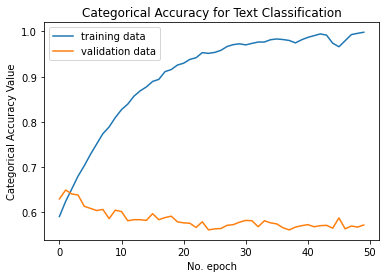

In [59]:
plot_accuracy(history4)

In [96]:
def evaluate_nn_model(filepath, X, y):
    model = load_model(filepath)
    yhat = model.predict(X)
    y_pred = [0 if p[0] > 0.5 else 1 for p in yhat]
    y_true = [0 if p[0] > 0.5 else 1 for p in y]
    return accuracy_score(y_true, y_pred)

In [61]:
evaluate_nn_model(filepath4, X_val, val_labels)

0.6479750778816199

In [62]:
model5 = Sequential()
model5.add(Dense(units=32, activation="relu"))
model5.add(Dense(units=64, activation="relu"))
model5.add(Dropout(0.1))
model5.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(units=2, activation="sigmoid"))

In [63]:
filepath5 = 'best_model_05.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath5, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history5 = model5.fit(X_train, train_labels,
              epochs=50,
              validation_data=(X_val, val_labels),
              batch_size=32,
              verbose=1,
              callbacks=callbacks)

Epoch 1/50
310/320 [============================>.] - ETA: 0s - loss: 0.8027 - accuracy: 0.5890
Epoch 1: val_accuracy improved from -inf to 0.62773, saving model to best_model_04.hdf5
320/320 [==============================] - 2s 4ms/step - loss: 0.7988 - accuracy: 0.5890 - val_loss: 0.6592 - val_accuracy: 0.6277
Epoch 2/50
308/320 [===========================>..] - ETA: 0s - loss: 0.6519 - accuracy: 0.6188
Epoch 2: val_accuracy improved from 0.62773 to 0.63707, saving model to best_model_04.hdf5
320/320 [==============================] - 1s 2ms/step - loss: 0.6522 - accuracy: 0.6176 - val_loss: 0.6566 - val_accuracy: 0.6371
Epoch 3/50
308/320 [===========================>..] - ETA: 0s - loss: 0.6401 - accuracy: 0.6374
Epoch 3: val_accuracy did not improve from 0.63707
320/320 [==============================] - 1s 2ms/step - loss: 0.6406 - accuracy: 0.6369 - val_loss: 0.6519 - val_accuracy: 0.6246
Epoch 4/50
311/320 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 

In [79]:
model6 = Sequential()
model6.add(Dense(units=32, activation="relu"))
model6.add(Dense(units=64, activation="relu"))
model6.add(Dropout(0.1))
model6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model6.add(Dropout(0.1))
model6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model6.add(Dense(units=64, activation="relu"))
model6.add(Dense(units=2, activation="sigmoid"))

In [80]:
filepath6 = 'best_model_06.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath6, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history6 = model6.fit(X_train, train_labels,
              epochs=50,
              validation_data=(X_val, val_labels),
              batch_size=32,
              verbose=1,
              callbacks=callbacks)

Epoch 1/50
312/320 [============================>.] - ETA: 0s - loss: 3.2906 - accuracy: 0.5718
Epoch 1: val_accuracy improved from -inf to 0.59579, saving model to best_model_06.hdf5
320/320 [==============================] - 2s 4ms/step - loss: 3.2258 - accuracy: 0.5739 - val_loss: 0.7129 - val_accuracy: 0.5958
Epoch 2/50
305/320 [===========================>..] - ETA: 0s - loss: 0.6727 - accuracy: 0.6011
Epoch 2: val_accuracy improved from 0.59579 to 0.63084, saving model to best_model_06.hdf5
320/320 [==============================] - 1s 3ms/step - loss: 0.6722 - accuracy: 0.6002 - val_loss: 0.6640 - val_accuracy: 0.6308
Epoch 3/50
301/320 [===========================>..] - ETA: 0s - loss: 0.6618 - accuracy: 0.6091
Epoch 3: val_accuracy did not improve from 0.63084
320/320 [==============================] - 1s 2ms/step - loss: 0.6614 - accuracy: 0.6098 - val_loss: 0.6632 - val_accuracy: 0.6285
Epoch 4/50
316/320 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 

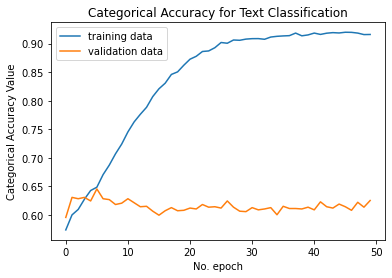

In [81]:
plot_accuracy(history6)

In [82]:
evaluate_nn_model(filepath6, X_val, val_labels)

0.6456386292834891

In [112]:
model7 = Sequential()
model7.add(Dense(units=32, activation="relu"))
model7.add(Dense(units=64, activation="relu"))
model7.add(Dropout(0.1))
model7.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model7.add(Dropout(0.1))
model7.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model7.add(Dense(units=2, activation="sigmoid"))

In [113]:
filepath7 = 'best_model_07.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath7, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model7.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

history7 = model7.fit(X_train, train_labels,
              epochs=50,
              validation_data=(X_val, val_labels),
              batch_size=32,
              verbose=1,
              callbacks=callbacks)

Epoch 1/50
308/320 [===========================>..] - ETA: 0s - loss: 11.1083 - accuracy: 0.5593
Epoch 1: val_accuracy improved from -inf to 0.52025, saving model to best_model_07.hdf5
320/320 [==============================] - 2s 3ms/step - loss: 11.0263 - accuracy: 0.5604 - val_loss: 8.8561 - val_accuracy: 0.5202
Epoch 2/50
314/320 [============================>.] - ETA: 0s - loss: 7.2364 - accuracy: 0.5627
Epoch 2: val_accuracy did not improve from 0.52025
320/320 [==============================] - 1s 2ms/step - loss: 7.2097 - accuracy: 0.5617 - val_loss: 5.7823 - val_accuracy: 0.5202
Epoch 3/50
310/320 [============================>.] - ETA: 0s - loss: 4.7262 - accuracy: 0.5611
Epoch 3: val_accuracy did not improve from 0.52025
320/320 [==============================] - 1s 2ms/step - loss: 4.6968 - accuracy: 0.5617 - val_loss: 3.7661 - val_accuracy: 0.5202
Epoch 4/50
299/320 [===========================>..] - ETA: 0s - loss: 3.1041 - accuracy: 0.5626
Epoch 4: val_accuracy did not i

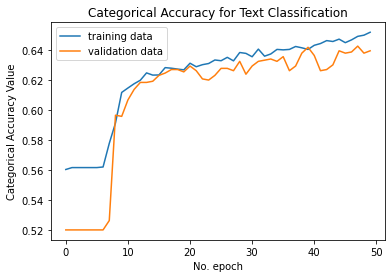

In [114]:
plot_accuracy(history7)

In [115]:
evaluate_nn_model(filepath7, X_val, val_labels)

0.6378504672897196

In [125]:
model8 = Sequential()
model8.add(Dense(units=32, activation="relu"))
model8.add(Dense(units=64, activation="relu"))
model8.add(Dropout(0.1))
model8.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model8.add(Dropout(0.1))
model8.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model8.add(Dense(units=2, activation="sigmoid"))

In [126]:
filepath8 = 'best_model_08.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath8, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

model8.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

history8 = model8.fit(X_train, train_labels,
              epochs=200,
              validation_data=(X_val, val_labels),
              batch_size=64,
              verbose=1,
              callbacks=callbacks)

Epoch 1/200
138/160 [========================>.....] - ETA: 0s - loss: 12.8676 - accuracy: 0.5592
Epoch 1: val_accuracy improved from -inf to 0.52025, saving model to best_model_08.hdf5
160/160 [==============================] - 1s 5ms/step - loss: 12.7759 - accuracy: 0.5598 - val_loss: 12.1116 - val_accuracy: 0.5202
Epoch 2/200
148/160 [==========================>...] - ETA: 0s - loss: 11.5389 - accuracy: 0.5622
Epoch 2: val_accuracy did not improve from 0.52025
160/160 [==============================] - 0s 3ms/step - loss: 11.4942 - accuracy: 0.5617 - val_loss: 10.8992 - val_accuracy: 0.5202
Epoch 3/200
157/160 [============================>.] - ETA: 0s - loss: 10.3503 - accuracy: 0.5618
Epoch 3: val_accuracy did not improve from 0.52025
160/160 [==============================] - 0s 3ms/step - loss: 10.3402 - accuracy: 0.5617 - val_loss: 9.8060 - val_accuracy: 0.5202
Epoch 4/200
142/160 [=========================>....] - ETA: 0s - loss: 9.3547 - accuracy: 0.5588
Epoch 4: val_accuracy

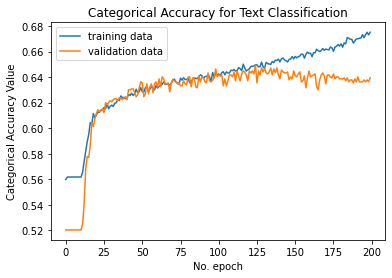

In [127]:
plot_accuracy(history8)

In [128]:
evaluate_nn_model(filepath8, X_val, val_labels)

0.647196261682243

In [165]:
print(f'NN Test Accuracy: {round(evaluate_nn_model(filepath8, X_val, val_labels), 4)}')

NN Test Accuracy: 0.6472


The Universal Sentence Encoders have been able to consistently perform better than the other techniques I used. I'll stop this fine tuning in it's eighth iteration and evaluate the model in the test data.

In [164]:
print(f'NN Test Accuracy: {round(evaluate_nn_model(filepath8, X_test, test_labels), 4)}')

NN Test Accuracy: 0.6212


The accuracy dropped slightly from the evaluation to the test data. That is to be expected and, given that it should happen with most model, I'm still happy to pick this one as my final model.

In [ ]:
# Get final model test predictions for confusion matrix
final_model = load_model(filepath8)
yhat = final_model.predict(X_test)
y_pred = [0 if p[0] > 0.5 else 1 for p in yhat]
y_true = [0 if p[0] > 0.5 else 1 for p in test_labels]

In [161]:
def print_cm_with_labels(y_true, 
                         y_pred):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    disp_labels = ['Fake', 'True']
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

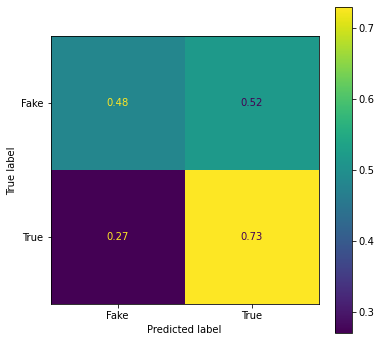

In [162]:
print_cm_with_labels(y_true, y_pred)

The model classifies correctly around 73% of the True statements, which is interesting to note, since it classifies correctly Fake statements only around 50% of the time. This might be the case of Fake statements trying to pass as True ones, and around 20% of them failing to do so in a convincing manner, or that the model had an easier time identifying True Positives because they're not actively trying to decieve the reader/listener. In either way, it will remain to be further studied, and you can find the rest of my analysis in the [Main Notebook](Main_Notebook.ipynb).

#### References

Daniel Cer, Yinfei Yang, Sheng-yi Kong, Nan Hua, Nicole Limtiaco, Rhomni St. John, Noah Constant, Mario Guajardo-Céspedes, Steve Yuan, Chris Tar, Yun-Hsuan Sung, Brian Strope, Ray Kurzweil. [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175). arXiv:1803.11175, 2018.